Data(x=[2000, 2], edge_index=[2, 579986], y=[2000])
Epoch 1, Loss: 1.3316676616668701
Epoch 2, Loss: 1.3300588130950928
Epoch 3, Loss: 1.3283731937408447
Epoch 4, Loss: 1.3266267776489258
Epoch 5, Loss: 1.3246991634368896
Epoch 6, Loss: 1.3225337266921997
Epoch 7, Loss: 1.3200970888137817
Epoch 8, Loss: 1.3173017501831055
Epoch 9, Loss: 1.3141056299209595
Epoch 10, Loss: 1.3103712797164917


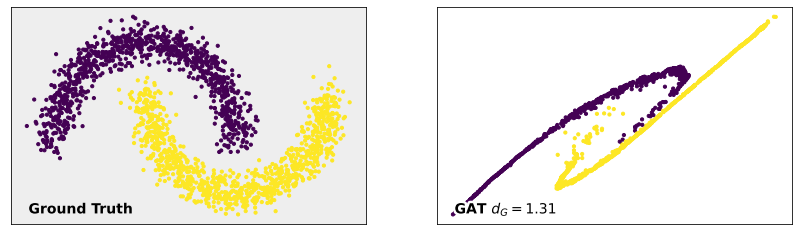

In [2]:
import os
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from scipy.sparse import csr_matrix
import networkx as nx

from scipy.linalg import orthogonal_procrustes

import torch
import torch.optim as optim
from torch_geometric.data import Data

from sklearn.manifold import TSNE
from sklearn.datasets import make_moons  # 导入make_moons函数

from util import Net, GIN, GAT, stationary, reconstruct, dG

np.random.seed(0)
torch.manual_seed(0)

n = 2000
m = 500
DISTANCE = 0.5

# 导入moon数据集
x, y = make_moons(n_samples=n, noise=0.1, random_state=0) 
# K = int(np.sqrt(n) * np.log2(n) / 10) #作为隐藏输入
D = pairwise_distances(x)# 邻接距离矩阵
# 二值化，得到邻接矩阵
A_binary = np.where(D <= DISTANCE, 1, 0)
# A_binary
# 获得所有的边，二元组格式
row_indices, col_indices = np.where(A_binary == 1)
edges = list(zip(row_indices, col_indices))

# 转为tensor
x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)
edges = torch.tensor(edges, dtype=torch.long).t().contiguous()
data = Data(x=x, y=y, edge_index=edges)
print(data)

# 喂到GAT网络中
net = GAT(m)
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.train()
for epoch in range(10):
    ind = torch.eye(n)[:, torch.randperm(n)[:m]]
    # 将节点选择矩阵与特征矩阵连接在一起
    X_extended = torch.hstack([x, ind])
    data = Data(x=X_extended, edge_index=edges)
    rec = net(data) # reconstruct
    loss = dG(x, rec) #train loss using the whole dataset
    print(f'Epoch {epoch + 1}, Loss: {float(loss)}')
    optimizer.zero_grad() # zero gradient
    loss.backward()
    optimizer.step()

R, _ = orthogonal_procrustes(x.numpy(), rec.detach().numpy())
rec_GAT = rec.detach().numpy() @ R.T
loss_GAT = float(dG(x, rec))
# 创建图形
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
# ax两个画布
ax[0].scatter(x[:, 0], x[:, 1], c=y, s=10, cmap='viridis', rasterized=True)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_facecolor('#eeeeee')
txt = ax[0].text(0.05, 0.05, 'Ground Truth', color='k', fontsize=14, weight='bold', transform=ax[0].transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='#eeeeee')])

# 绘制 GAT 网络的重构结果
ax[1].scatter(rec_GAT[:, 0], rec_GAT[:, 1], c=y, s=10, cmap='viridis', rasterized=True)
ax[1].set_xticks([])
ax[1].set_yticks([])
txt = ax[1].text(0.05, 0.05, f'GAT $d_G = {loss_GAT:.2f}$', color='k', fontsize=14, weight='bold', transform=ax[1].transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

fig.subplots_adjust()

if not os.path.exists('imgs'):
    os.mkdir('imgs')

fig.savefig('imgs/semi_moon_GAT.png', bbox_inches='tight', dpi=300)

plt.show()
